# Data Science For Biology 2025 Final Project

# Protein Sequence Mutation

## Libraries & Packages

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from scipy.stats import pearsonr

from transformers import AutoTokenizer, AutoModel
import torch
from dotenv import load_dotenv
import os
import numpy as np
from tqdm import tqdm

## Data Loading

In [49]:
data = pd.read_csv("./gcn4-orthologs.csv")
data = data.rename(columns={data.columns[0]: "tile_id"})
data.head()

,tile_id,DNAseq,ADseq,numreads_per_AD_7AGFP_AAS,Activity_7AGFP_AAS,numreads_per_AD_8AmCh_AAS,Activity_8AmCh_AAS,numreads_per_AD_9ARatio_AAS,Activity_9ARatio_AAS,numreads_per_AD_10BRatio_AAS,...,Activity_BYS4_BioRepAverage,Stdev_BYS4_BioReps,Activity_SCglucose,Start,Recovered,Activity_SCgalactose,Activity_P3promoter,Activity_P14promoter,Activity_P15promoter,Activity_P3promoterMig1TFBSremoved
0,0,AAAAATTCTAGATTTGTTTCTTTGATGCAAGGATTCTCTGATGGTT...,KNSRFVSLMQGFSDGSKDIIDNEVREVGDFSVNKPPQADD,NaN,NaN,NaN,NaN,NaN,NaN,3151.0,...,NaN,NaN,11666.48682,341,True,97250.68362,NaN,11149.49032,NaN,8040.343648
1,1,AAAAATTCTCCATCTGGTTTGGCTCATTCTTCTGTTTCTGGTGTTG...,KNSPSGLAHSSVSGVGKSRRRKGPLPPITVQDPSDKTAIK,942.0,709.606092,367.0,2921.917252,601.0,22242.74698,6909.0,...,21968.05843,5849.143385,21968.05843,146,True,15516.96245,14570.13217,16872.28649,11555.08411,10255.296840
2,2,AAACAAAATTCTCAAGTTGATCAATCTCCATTGTTGCCAGAAGAAG...,KQNSQVDQSPLLPEEELEVSEHLRRRRSGTATSPPAGGVR,NaN,NaN,NaN,NaN,NaN,NaN,6577.0,...,NaN,NaN,21203.02478,326,True,0.00000,18274.98241,15702.60901,18303.29201,17265.783330
3,3,AAACAAAGAGCTACTCCATTGACTCCAGTTGTTCCAGAATCTGATG...,KQRATPLTPVVPESDDPVALKRARNTEAARRSRARKLERM,357.0,1039.469842,342.0,1089.428196,450.0,74251.36241,NaN,...,NaN,NaN,47244.41248,246,True,92844.00000,NaN,NaN,NaN,84807.518160
4,4,AAACAAAGATCTATTCCATTGTCTCCAATTGTTCCAGAATCTTCTG...,KQRSIPLSPIVPESSDPAALKRARNTEAARRSRARKLQRM,539.0,1081.980998,627.0,622.131501,586.0,58872.95132,128.0,...,95093.69451,13292.686710,95093.69451,211,True,76399.62949,NaN,125056.17980,129302.35080,100360.735500


In [50]:
len(data.iloc[0, 2])

40

In [51]:
num_rows = data.shape[0]
num_cols = data.shape[1]

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 19038
Number of columns: 35


### Data Exploration
First, we will start by analyzing the data for missing values

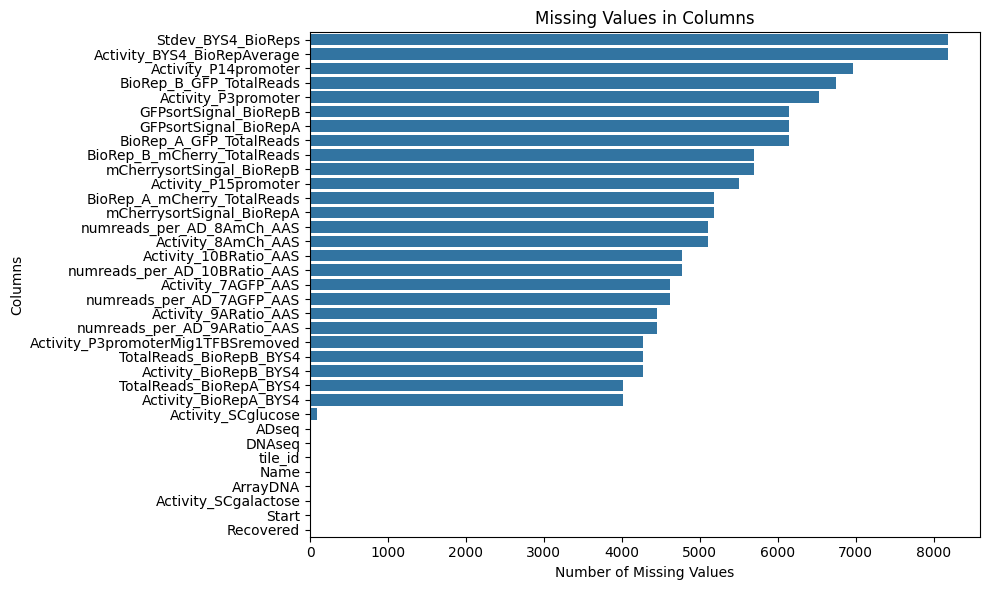

In [52]:
# Bar chart for missing values hprizontally
missing_values = data.isnull().sum()
#missing_values = missing_values[missing_values > 0]
missing_values = missing_values.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values.values, y=missing_values.index, orient="h")
plt.xlabel("Number of Missing Values")
plt.ylabel("Columns")
plt.title("Missing Values in Columns")
plt.tight_layout()
#plt.savefig("GCN4_missing_values.png")
plt.show()

There are quite a lot of zeroes but here we recall that the doc explicitly mentions that the tile with `NaN` activities really means that they were not measured at all. So, intuitively, it dos not make sense to treat these values as  zero-activity values since this would mislead our model into thinking that these tiles are just functionally silent.

As per the final project warmup, it will be good to only consider the rows with a higher sequencing reads since those with very low sequencing reads can be introduce noise when we begin modelling. To this end, we set a introduce a new hyperparameter `read_threshold` that will allow us to filter the dataset for rows with reads greater than or equal to the arbitrarily specified `read_threshold`

In [53]:
read_threshold = 1000 # threshold for read count

df_filtered = data[(data['TotalReads_BioRepA_BYS4'] >= read_threshold) & (data['TotalReads_BioRepB_BYS4'] >= read_threshold)]
print(f"Number of rows before filtering: {num_rows}")
print(f"Number of rows removed: {num_rows - df_filtered.shape[0]}")
print(f"Number of rows after filtering: {df_filtered.shape[0]}")

Number of rows before filtering: 19038
Number of rows removed: 9985
Number of rows after filtering: 9053


For a baseline model, we will use `Activity_SCglucose` as a baseline activity measurement since I believe the project doc mentioned it is the most well-characterized condition in the dataset. Since the project doc says that zeroes represent unmeasured quantities, I will drop these rows to prevent additional noise in our data

In [54]:
activity_col = "Activity_SCglucose"
df_filtered = df_filtered[df_filtered[activity_col] > 0]

print(f"Number of rows after filtering for non-zero {activity_col}: {df_filtered.shape[0]}")

Number of rows after filtering for non-zero Activity_SCglucose: 9053


In [55]:
df_with_seq = df_filtered.copy()

## Feature Engineering
Section to add new features inferred from existing columns like net charge

In [56]:
# FEATURES

# variables I need glovally
AA_LIST = 'ACDEFGHIKLMNPQRSTVWY'
AA_COLS = [f"AA_{aa}" for aa in AA_LIST]

# I use Kyte-Doolittle scale for hydrophobicity hereee CHECK WITH PROF STALLER
# https://www.rbvi.ucsf.edu/chimera/docs/UsersGuide/midas/hydrophob.html
KD_HYDROPHOBICITY = {
    'A': 1.8, 'C': 2.5, 'D': -3.5, 'E': -3.5, 'F': 2.8,
    'G': -0.4, 'H': -3.2, 'I': 4.5, 'K': -3.9, 'L': 3.8,
    'M': 1.9, 'N': -3.5, 'P': -1.6, 'Q': -3.5, 'R': -4.5,
    'S': -0.8, 'T': -0.7, 'V': 4.2, 'W': -0.9, 'Y': -1.3
}

# i use the tuple here for naming the motifs
MOTIFS = [
    ("W..LF", "W..LF"),
    ("WFYL_WFYL", "[WFYL]..[WFYL][WFYL]"),
    ("WFL_WFL", "[WFL]..[WFL][WFL]"),
    ("DE_WFY", "[DE][WFY]"),
    ("DE_WF", "[DE][WF]"),
    ("DE_L", "[DE][L]"),
    ("DE_x_WFY", "[DE].[WFY]"),
    ("DE_xx_WFY", "[DE]..[WFY]"),
    ("FF", "FF"),
    ("F_F", "F.F"),
    ("F__F", "F..F"),
    ("FY_5x_FY", "[FY].....[FY]"),
    ("SP", "SP"),
    ("WFYL_3x_WFYL", "[WFYL]...[WFYL][WFYL]")
]

# FUNCTIONS TO CALC

def amino_acid_count(sequence: str) -> dict[str, int]:
    c = Counter(sequence)
    return {f"AA_{aa}": c.get(aa, 0) for aa in AA_LIST}

def net_charge(seq: str) -> int:
    charge_map = {"K": 1, "R": 1, "D": -1, "E": -1}
    return sum(charge_map.get(a, 0) for a in seq)

def hydrophobicity(sequence: str) -> float:
    total_hydrophobicity = sum(KD_HYDROPHOBICITY[aa] for aa in sequence if aa in KD_HYDROPHOBICITY)
    return total_hydrophobicity

def motif_counts_dict(seq: str) -> dict[str, int]:
    return {name: len(re.findall(pat, seq)) for name, pat in MOTIFS}

# APPLY DA FEATURESSSS
def add_sequence_features(df: pd.DataFrame, seq_col: str = "ADseq") -> pd.DataFrame:
    # AA composition
    aa_expanded = df[seq_col].apply(amino_acid_count).apply(pd.Series)
    
    # Motif counts
    motif_expanded = df[seq_col].apply(motif_counts_dict).apply(pd.Series)

    # Scalar features
    df["NetCharge"] = df[seq_col].apply(net_charge)
    df["Hydrophobicity"] = df[seq_col].apply(hydrophobicity)
    
    # Sequence length
    df["Length"] = df[seq_col].str.len()

    # Combine everything
    result_df = pd.concat([df, aa_expanded, motif_expanded], axis=1)

    return result_df

In [57]:
# Apply features to the filtered DataFrame
df_filtered = add_sequence_features(df_filtered)
df_filtered.iloc[:, 35:]

,NetCharge,Hydrophobicity,Length,AA_A,AA_C,AA_D,AA_E,AA_F,AA_G,AA_H,...,DE_WF,DE_L,DE_x_WFY,DE_xx_WFY,FF,F_F,F__F,FY_5x_FY,SP,WFYL_3x_WFYL
1,6,-34.0,40,2,0,2,0,0,4,1,...,0,0,0,0,0,0,0,0,1,0
7,1,-24.2,40,3,1,2,1,1,3,3,...,0,0,0,0,0,0,0,0,0,0
8,2,-36.7,40,2,0,3,0,0,2,1,...,0,0,1,0,0,0,0,0,2,0
12,-4,-13.8,40,6,0,4,2,4,3,0,...,1,3,0,1,0,0,1,0,1,0
18,6,-24.4,40,5,0,0,1,2,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19021,-1,-33.9,40,2,0,3,1,4,0,4,...,1,0,0,1,0,0,1,0,1,0
19030,-6,19.9,40,3,1,6,0,3,1,0,...,0,1,0,1,0,0,0,0,0,0
19033,-7,-42.3,40,1,0,5,3,2,2,1,...,0,1,1,1,0,0,0,0,1,0
19036,2,27.8,40,5,2,1,0,2,3,2,...,0,0,0,0,0,0,0,0,1,0


## Feature Selection
FOr now I'm gonna use all of them

In [58]:
X = df_filtered.iloc[:, 35:]
y = df_filtered[activity_col]


# now i structure the final prep data
df = pd.concat([X, y], axis=1)

assert df.isna().sum().sum() == 0, "Features contain NaNs"

# quick sanity check for missing values
print("Missing values in final data:")
print(df.isnull().sum())

Missing values in final data:
NetCharge             0
Hydrophobicity        0
Length                0
AA_A                  0
AA_C                  0
AA_D                  0
AA_E                  0
AA_F                  0
AA_G                  0
AA_H                  0
AA_I                  0
AA_K                  0
AA_L                  0
AA_M                  0
AA_N                  0
AA_P                  0
AA_Q                  0
AA_R                  0
AA_S                  0
AA_T                  0
AA_V                  0
AA_W                  0
AA_Y                  0
W..LF                 0
WFYL_WFYL             0
WFL_WFL               0
DE_WFY                0
DE_WF                 0
DE_L                  0
DE_x_WFY              0
DE_xx_WFY             0
FF                    0
F_F                   0
F__F                  0
FY_5x_FY              0
SP                    0
WFYL_3x_WFYL          0
Activity_SCglucose    0
dtype: int64


In [59]:
df.head()

,NetCharge,Hydrophobicity,Length,AA_A,AA_C,AA_D,AA_E,AA_F,AA_G,AA_H,...,DE_L,DE_x_WFY,DE_xx_WFY,FF,F_F,F__F,FY_5x_FY,SP,WFYL_3x_WFYL,Activity_SCglucose
1,6,-34.0,40,2,0,2,0,0,4,1,...,0,0,0,0,0,0,0,1,0,21968.05843
7,1,-24.2,40,3,1,2,1,1,3,3,...,0,0,0,0,0,0,0,0,0,70876.84864
8,2,-36.7,40,2,0,3,0,0,2,1,...,0,1,0,0,0,0,0,2,0,16850.74599
12,-4,-13.8,40,6,0,4,2,4,3,0,...,3,0,1,0,0,1,0,1,0,226681.83670
18,6,-24.4,40,5,0,0,1,2,0,1,...,0,0,0,0,0,0,0,1,0,33491.53797


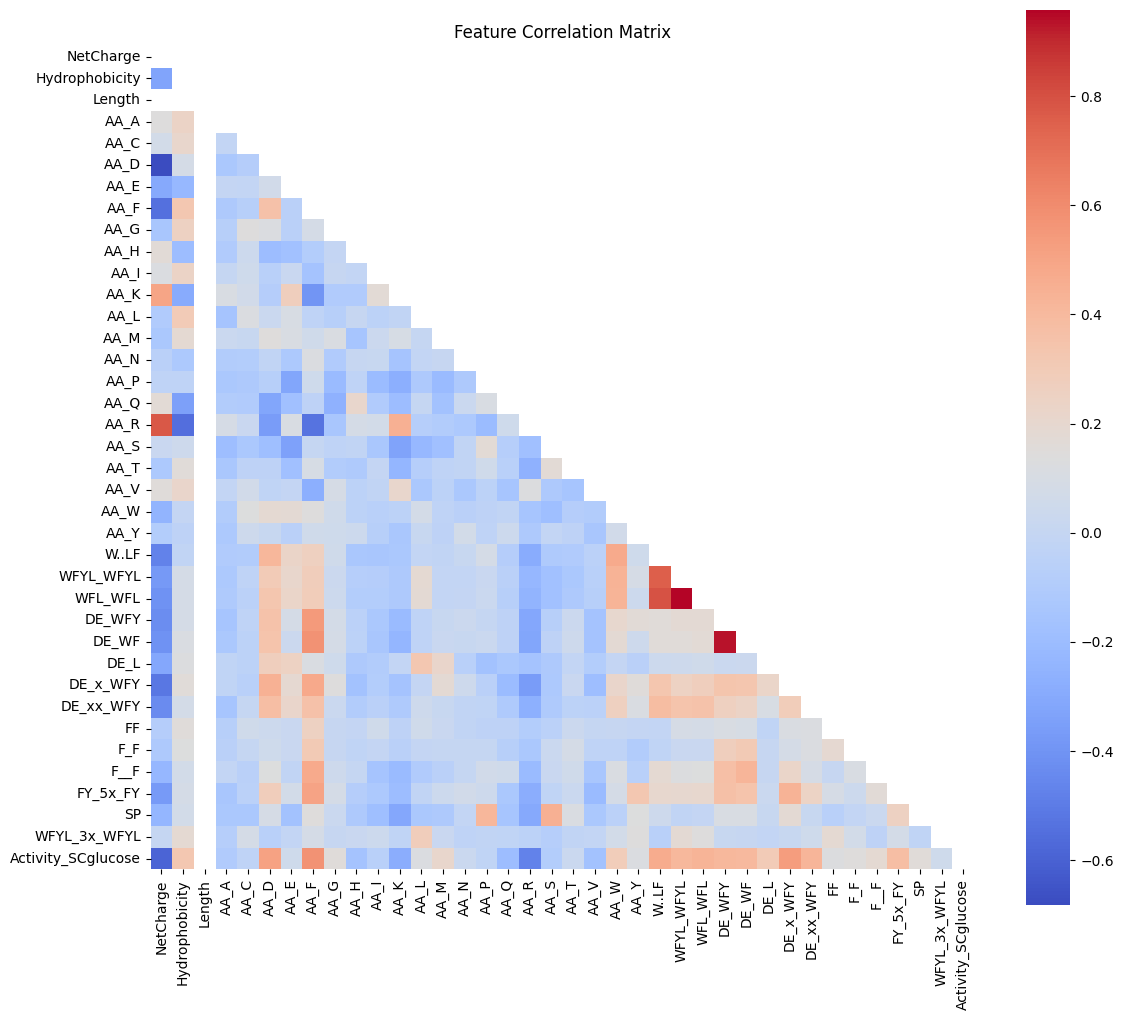

In [60]:
# Check correlation matrix
plt.figure(figsize=(12, 12))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap="coolwarm", annot=False, fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title("Feature Correlation Matrix")
plt.tight_layout()
#plt.savefig("GCN4_correlation_matrix.png")
plt.show()

## Baseline Model Development

In typical ML fashion, we begin by splitting our data into a train and test set. Also, since the target values are much higher than our engineered features, we will have to scale it appropriately. I'm just going to use Z-Score normalization which is implemented out of the box via sklearn's `StandardScaler` class.

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Cool, now that we have train and test set, we're going to build multiple baseline models, i will try lasso and ridge regression

In [62]:
ridge_reg = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
ridge_reg.fit(X_train, y_train)
ridge_reg_y_pred = ridge_reg.predict(X_test)

#  just print for now
print("Ridge Regression Results:")
print(f"R^2: {r2_score(y_test, ridge_reg_y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, ridge_reg_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_test, ridge_reg_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_test, ridge_reg_y_pred)[0]}")

Ridge Regression Results:
R^2: 0.6201281103997202
MAE: 28987.144163384466
RMSE: 39767.08032290962
Pearson Correlation: 0.7876414833027815


In [63]:
lasso_reg = make_pipeline(StandardScaler(), Lasso(alpha=1.0, max_iter=100000))
lasso_reg.fit(X_train, y_train)
lasso_reg_y_pred = lasso_reg.predict(X_test)

print("Lasso Regression Results:")
print(f"R^2: {r2_score(y_test, lasso_reg_y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, lasso_reg_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_test, lasso_reg_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_test, lasso_reg_y_pred)[0]}")

Lasso Regression Results:
R^2: 0.6201318526495319
MAE: 28986.773807345686
RMSE: 39766.88444277287
Pearson Correlation: 0.7876439144538867


In [69]:
grad_boost_reg = make_pipeline(StandardScaler(), GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
grad_boost_reg.fit(X_train, y_train)
grad_boost_reg_y_pred = grad_boost_reg.predict(X_test)

print("Gradient Boosting Regressor Results:")
print(f"R^2: {r2_score(y_test, grad_boost_reg_y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, grad_boost_reg_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_test, grad_boost_reg_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_test, grad_boost_reg_y_pred)[0]}")

Gradient Boosting Regressor Results:
R^2: 0.753700802349068
MAE: 22520.370014086355
RMSE: 32021.127989379256
Pearson Correlation: 0.8700241578562002


In [70]:
random_forest_reg = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42))
random_forest_reg.fit(X_train, y_train)
random_forest_y_pred = random_forest_reg.predict(X_test)

print("Random Forest Regressor Results:")
print(f"R^2: {r2_score(y_test, random_forest_y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, random_forest_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_test, random_forest_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_test, random_forest_y_pred)[0]}")

Random Forest Regressor Results:
R^2: 0.7961507641413464
MAE: 20054.764553828776
RMSE: 29131.28699844031
Pearson Correlation: 0.8929759233179536


### Baseline Model Evaluation

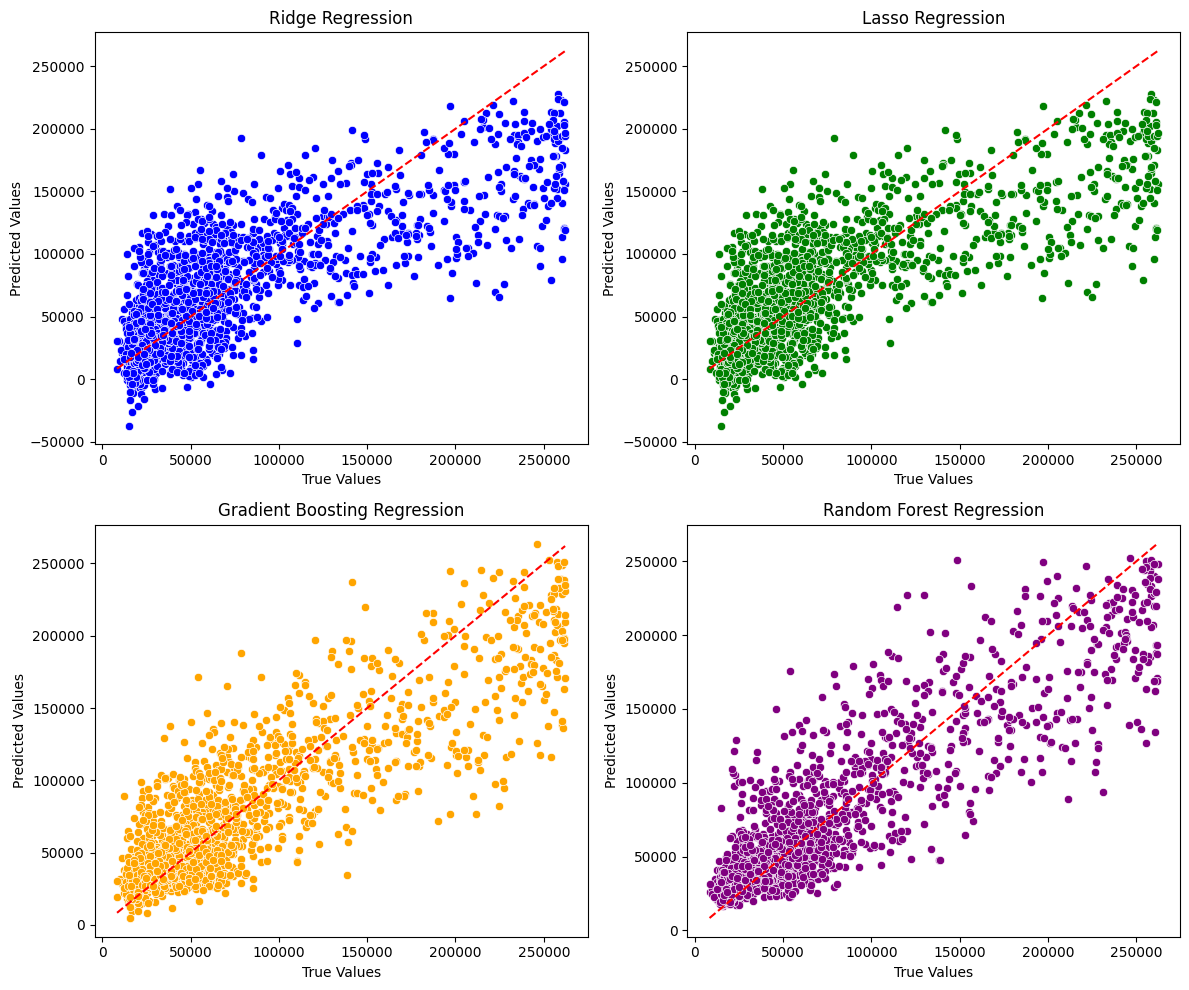

In [71]:
# Make subplots for each model
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Ridge Regression
sns.scatterplot(x=y_test, y=ridge_reg_y_pred, ax=axes[0], color='blue')
axes[0].set_title("Ridge Regression")
axes[0].set_xlabel("True Values")
axes[0].set_ylabel("Predicted Values")
sns.lineplot(x=y_test, y=y_test, ax=axes[0], color='red', linestyle='--')

# Lasso Regression
sns.scatterplot(x=y_test, y=lasso_reg_y_pred, ax=axes[1], color='green')
axes[1].set_title("Lasso Regression")
axes[1].set_xlabel("True Values")
axes[1].set_ylabel("Predicted Values")
sns.lineplot(x=y_test, y=y_test, ax=axes[1], color='red', linestyle='--')

# Linear Regression
sns.scatterplot(x=y_test, y=grad_boost_reg_y_pred, ax=axes[2], color='orange')
axes[2].set_title("Gradient Boosting Regression")
axes[2].set_xlabel("True Values")
axes[2].set_ylabel("Predicted Values")
sns.lineplot(x=y_test, y=y_test, ax=axes[2], color='red', linestyle='--')

# Random Forest Regression
sns.scatterplot(x=y_test, y=random_forest_y_pred, ax=axes[3], color='purple')
axes[3].set_title("Random Forest Regression")
axes[3].set_xlabel("True Values")
axes[3].set_ylabel("Predicted Values")
sns.lineplot(x=y_test, y=y_test, ax=axes[3], color='red', linestyle='--')

plt.tight_layout()
plt.show()


In [72]:
# Make df of results
results = {
    "Model": ["Ridge", "Lasso", "Gradient Boosting", "Random Forest"],
    "R^2": [
        r2_score(y_test, ridge_reg_y_pred),
        r2_score(y_test, lasso_reg_y_pred),
        r2_score(y_test, grad_boost_reg_y_pred),
        r2_score(y_test, random_forest_y_pred)
    ],
    "MAE": [
        mean_absolute_error(y_test, ridge_reg_y_pred),
        mean_absolute_error(y_test, lasso_reg_y_pred),
        mean_absolute_error(y_test, grad_boost_reg_y_pred),
        mean_absolute_error(y_test, random_forest_y_pred)
    ],
    "RMSE": [
        root_mean_squared_error(y_test, ridge_reg_y_pred),
        root_mean_squared_error(y_test, lasso_reg_y_pred),
        root_mean_squared_error(y_test, grad_boost_reg_y_pred),
        root_mean_squared_error(y_test, random_forest_y_pred)
    ],
    "Pearson Correlation": [
        pearsonr(y_test, ridge_reg_y_pred)[0],
        pearsonr(y_test, lasso_reg_y_pred)[0],
        pearsonr(y_test, grad_boost_reg_y_pred)[0],
        pearsonr(y_test, random_forest_y_pred)[0]
    ]
}
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="R^2", ascending=False).reset_index(drop=True)   
results_df.head()

,Model,R^2,MAE,RMSE,Pearson Correlation
0,Random Forest,0.796151,20054.764554,29131.286998,0.892976
1,Gradient Boosting,0.753701,22520.370014,32021.127989,0.870024
2,Lasso,0.620132,28986.773807,39766.884443,0.787644
3,Ridge,0.620128,28987.144163,39767.080323,0.787641


## Feature Importances Analysis

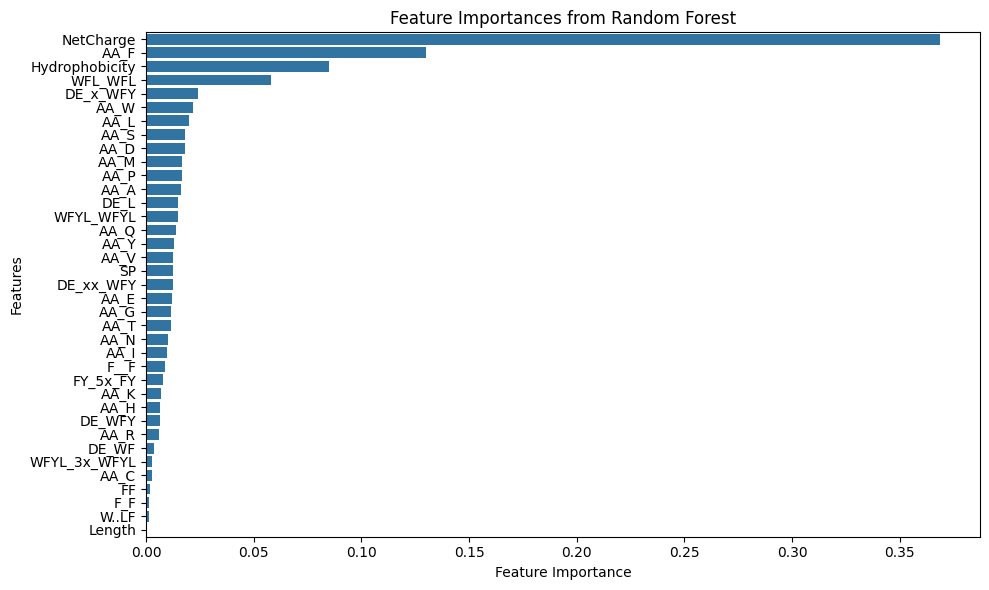

In [21]:
feature_importances = random_forest_reg.named_steps['randomforestregressor'].feature_importances_
feature_names = X.columns
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_feature_importances, y=sorted_feature_names)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importances from Random Forest")
plt.tight_layout()
#plt.savefig("GCN4_feature_importances.png")
plt.show()

## Protein Language Model (PLM) Features

Here I will be utilizing the Evolutionary Scale Model 2 produced by Facebook AI Research. In particular, I will be utilizing the 8M parameter version to generate feature-rich embeddings to train some baseline models. We set load the model below and run it on inference mode to generate these embeddings. To ensure this runs without any issues, please ensure you have set the `HF_TOKEN` in the .env file!

We will first augment our existing engineered features with these embeddings, and below I will perform an ablation study for further analysis on which features actually mattered

### Feature Extraction

In [ ]:
# Load the .env file
load_dotenv()
hf_token = os.getenv("HF_TOKEN")

# Load model and tokenizer once
model_id = "facebook/esm2_t6_8M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_id, token=hf_token)
model = AutoModel.from_pretrained(model_id, token=hf_token)
model.eval()

def generate_embedding(sequence):
    """Generate pooled ESM embedding for a protein sequence."""
    input_ids = tokenizer(sequence, return_tensors="pt").input_ids
    attention_mask = torch.ones_like(input_ids)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        sequence_embeddings = outputs.last_hidden_state.squeeze()

    # Remove special tokens [CLS], [EOS]
    sequence_embeddings = sequence_embeddings[1:-1]

    # Mean-pool across residues
    pooled_embedding = sequence_embeddings.mean(dim=0)  # shape: (hidden_size,)
    return pooled_embedding.cpu().numpy()

def save_embeddings_to_npz(data, sequence_column, save_path):
    """Generate embeddings for all sequences and save into a single NPZ file."""
    all_embeddings = []

    for sequence in tqdm(data[sequence_column], desc="Generating embeddings"):
        embedding = generate_embedding(sequence)
        all_embeddings.append(embedding)

    all_embeddings = np.stack(all_embeddings)  # Shape: (num_sequences, hidden_dim)

    np.savez_compressed(save_path, embeddings=all_embeddings)
    print(f"Saved {len(all_embeddings)} embeddings to {save_path}")

# Comment out when not needed
# save_embeddings_to_npz(df_with_seq, sequence_column="ADseq", save_path="./esm2_embeddings.npz")


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Generating embeddings: 100%|██████████| 9053/9053 [02:02<00:00, 73.71it/s] 


Saved 9053 embeddings to ./esm2_embeddings.npz


### Training Baseline Models With PLM Embeddings

In [28]:
# Load the embeddings from the NPZ file
embeddings_data = np.load("./esm2_embeddings.npz")
embeddings = embeddings_data["embeddings"]

# Check the shape of the loaded embeddings
print(f"Loaded embeddings shape: {embeddings.shape}")

Loaded embeddings shape: (9053, 320)


In [ ]:
# Prep embededings into a dataframe for feature concatenation
embeddings_df = pd.DataFrame(embeddings)
embeddings_df.columns = [f"embedding_{i}" for i in range(embeddings_df.shape[1])]
embeddings_df.head(3)

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_310,embedding_311,embedding_312,embedding_313,embedding_314,embedding_315,embedding_316,embedding_317,embedding_318,embedding_319
0,-0.025192,-0.386163,0.038171,0.142583,0.045324,-0.185973,-0.089887,0.023278,-0.155760,-0.039424,...,0.242718,-0.096438,0.113960,0.213151,-0.079959,0.146884,-0.072922,0.234120,-0.032808,0.050551
1,0.014334,-0.416917,0.232792,0.121774,-0.028585,-0.204531,-0.152476,0.021117,-0.132263,-0.106221,...,0.087891,-0.152725,0.103766,0.121723,-0.077505,0.077167,-0.150012,0.081626,0.134874,0.011173
2,-0.005063,-0.397236,-0.005174,0.114196,0.172707,-0.098770,-0.020182,0.004256,-0.168792,-0.136290,...,0.192599,-0.115246,0.148075,0.255852,-0.075508,0.183582,-0.043454,0.221282,0.090849,0.028793


In [44]:
# the assert below is for me to chek for dimension mismatch
assert embeddings_df.shape[0] == df_filtered.shape[0], "Mismatch in number of rows between embeddings and original DataFrame"

# Concatenate the embeddings with the original DataFrame
X_esm = pd.concat([X.reset_index(drop=True),
                   embeddings_df.reset_index(drop=True)],
                  axis=1)
y_esm = y.copy()

print(f"X_esm shape: {X_esm.shape}")
print(f"y_esm shape: {y_esm.shape}")

X_esm shape: (9053, 357)
y_esm shape: (9053,)


In [45]:
X_esm_train, X_esm_test, y_esm_train, y_esm_test = train_test_split(X_esm, y_esm, test_size=0.2, random_state=42)

In [78]:
esm_ridge_reg = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
esm_ridge_reg.fit(X_esm_train, y_esm_train)
esm_ridge_reg_y_pred = esm_ridge_reg.predict(X_esm_test)

#  just print for now
print("Ridge Regression Results:")
print(f"R^2: {r2_score(y_esm_test, esm_ridge_reg_y_pred)}")
print(f"MAE: {mean_absolute_error(y_esm_test, esm_ridge_reg_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_esm_test, esm_ridge_reg_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_esm_test, esm_ridge_reg_y_pred)[0]}")

Ridge Regression Results:
R^2: 0.7511689855279073
MAE: 24034.42004925025
RMSE: 32185.286769800612
Pearson Correlation: 0.8667569536805928


In [79]:
esm_lasso_reg = make_pipeline(StandardScaler(), Lasso(alpha=1.0, max_iter=100000))
esm_lasso_reg.fit(X_esm_train, y_esm_train)
esm_lasso_reg_y_pred = esm_lasso_reg.predict(X_esm_test)

print("Lasso Regression Results:")
print(f"R^2: {r2_score(y_esm_test, esm_lasso_reg_y_pred)}")
print(f"MAE: {mean_absolute_error(y_esm_test, esm_lasso_reg_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_esm_test, esm_lasso_reg_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_esm_test, esm_lasso_reg_y_pred)[0]}")

Lasso Regression Results:
R^2: 0.7510949161147215
MAE: 24038.644276263833
RMSE: 32190.0767030988
Pearson Correlation: 0.8667134451972629


In [81]:
esm_random_forest_reg = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42))
esm_random_forest_reg.fit(X_esm_train, y_esm_train)
esm_random_forest_y_pred = esm_random_forest_reg.predict(X_esm_test)

print("Random Forest Regressor Results:")
print(f"R^2: {r2_score(y_esm_test, esm_random_forest_y_pred)}")
print(f"MAE: {mean_absolute_error(y_esm_test, esm_random_forest_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_esm_test, esm_random_forest_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_esm_test, esm_random_forest_y_pred)[0]}")

Random Forest Regressor Results:
R^2: 0.7835303977910969
MAE: 21023.834547198785
RMSE: 30019.509197396503
Pearson Correlation: 0.8880259233277831


In [82]:
esm_grad_boost_reg = make_pipeline(StandardScaler(), GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
esm_grad_boost_reg.fit(X_esm_train, y_esm_train)
esm_grad_boost_reg_y_pred = esm_grad_boost_reg.predict(X_esm_test)

print("Gradient Boosting Regressor Results:")
print(f"R^2: {r2_score(y_esm_test, esm_grad_boost_reg_y_pred)}")
print(f"MAE: {mean_absolute_error(y_esm_test, esm_grad_boost_reg_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_esm_test, esm_grad_boost_reg_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_esm_test, esm_grad_boost_reg_y_pred)[0]}")

Gradient Boosting Regressor Results:
R^2: 0.7703598638819741
MAE: 21776.798479821453
RMSE: 30919.25533619557
Pearson Correlation: 0.8782237127326246


### Result Analysis: Features Augmented With PLM Embeddings

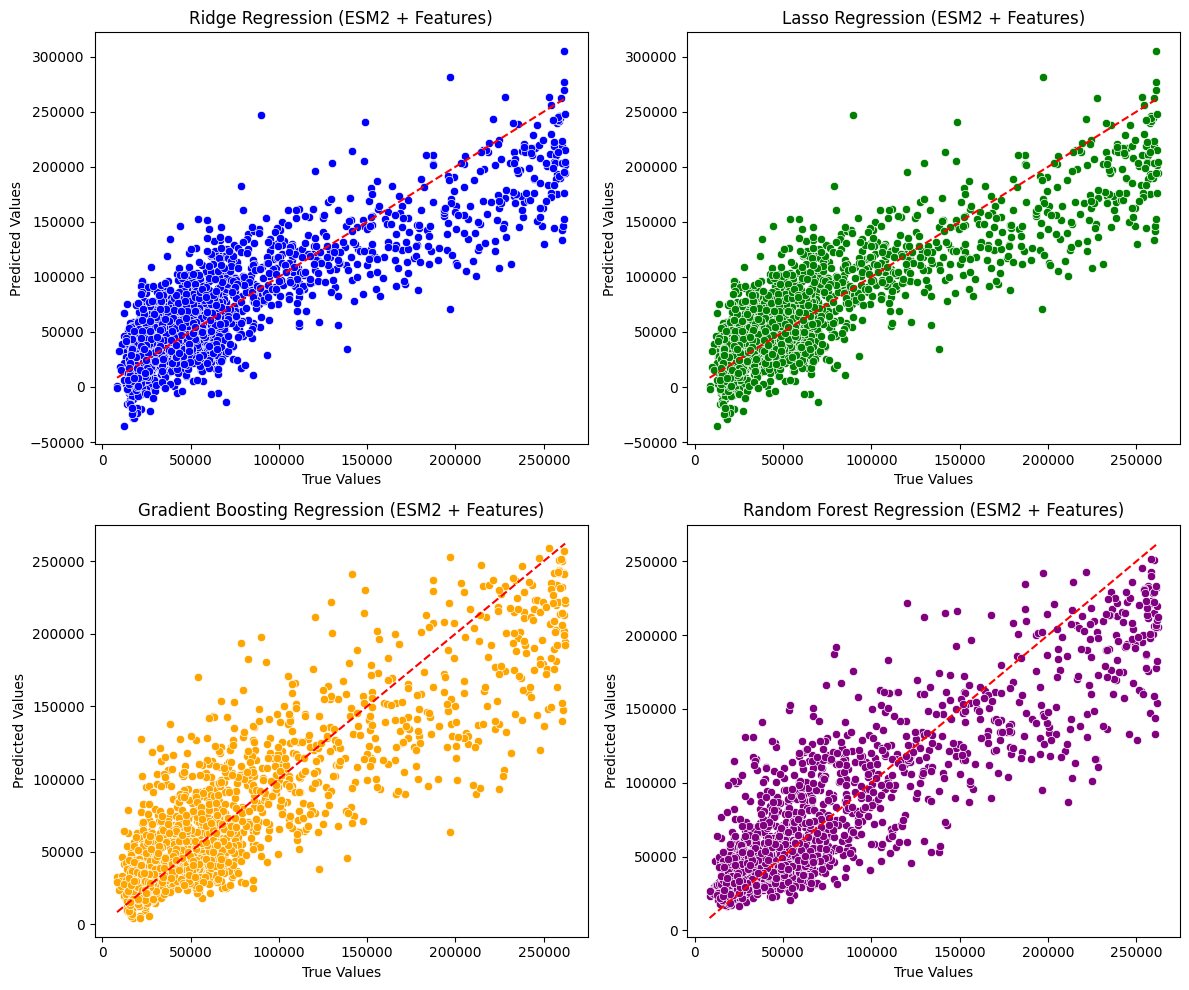

In [85]:
# Make subplots for each model
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Ridge Regression
sns.scatterplot(x=y_esm_test, y=esm_ridge_reg_y_pred, ax=axes[0], color='blue')
axes[0].set_title("Ridge Regression (ESM2 + Features)")
axes[0].set_xlabel("True Values")
axes[0].set_ylabel("Predicted Values")
sns.lineplot(x=y_esm_test, y=y_esm_test, ax=axes[0], color='red', linestyle='--')

# Lasso Regression
sns.scatterplot(x=y_esm_test, y=esm_lasso_reg_y_pred, ax=axes[1], color='green')
axes[1].set_title("Lasso Regression (ESM2 + Features)")
axes[1].set_xlabel("True Values")
axes[1].set_ylabel("Predicted Values")
sns.lineplot(x=y_esm_test, y=y_esm_test, ax=axes[1], color='red', linestyle='--')

# Linear Regression
sns.scatterplot(x=y_esm_test, y=esm_grad_boost_reg_y_pred, ax=axes[2], color='orange')
axes[2].set_title("Gradient Boosting Regression (ESM2 + Features)")
axes[2].set_xlabel("True Values")
axes[2].set_ylabel("Predicted Values")
sns.lineplot(x=y_esm_test, y=y_esm_test, ax=axes[2], color='red', linestyle='--')

# Random Forest Regression
sns.scatterplot(x=y_esm_test, y=esm_random_forest_y_pred, ax=axes[3], color='purple')
axes[3].set_title("Random Forest Regression (ESM2 + Features)")
axes[3].set_xlabel("True Values")
axes[3].set_ylabel("Predicted Values")
sns.lineplot(x=y_esm_test, y=y_esm_test, ax=axes[3], color='red', linestyle='--')

plt.tight_layout()
plt.show()


In [86]:
# Make df of results
esm_results = {
    "Model": ["Ridge (ESM)", "Lasso (ESM)", "Gradient Boosting (ESM)", "Random Forest (ESM)"],
    "R^2": [
        r2_score(y_esm_test, esm_ridge_reg_y_pred),
        r2_score(y_esm_test, esm_lasso_reg_y_pred),
        r2_score(y_esm_test, esm_grad_boost_reg_y_pred),
        r2_score(y_esm_test, esm_random_forest_y_pred)
    ],
    "MAE": [
        mean_absolute_error(y_esm_test, esm_ridge_reg_y_pred),
        mean_absolute_error(y_esm_test, esm_lasso_reg_y_pred),
        mean_absolute_error(y_esm_test, esm_grad_boost_reg_y_pred),
        mean_absolute_error(y_esm_test, esm_random_forest_y_pred)
    ],
    "RMSE": [
        root_mean_squared_error(y_esm_test, esm_ridge_reg_y_pred),
        root_mean_squared_error(y_esm_test, esm_lasso_reg_y_pred),
        root_mean_squared_error(y_esm_test, esm_grad_boost_reg_y_pred),
        root_mean_squared_error(y_esm_test, esm_random_forest_y_pred)
    ],
    "Pearson Correlation": [
        pearsonr(y_esm_test, esm_ridge_reg_y_pred)[0],
        pearsonr(y_esm_test, esm_lasso_reg_y_pred)[0],
        pearsonr(y_esm_test, esm_grad_boost_reg_y_pred)[0],
        pearsonr(y_esm_test, esm_random_forest_y_pred)[0]
    ]
}
esm_results_df = pd.DataFrame(esm_results)
esm_results_df = esm_results_df.sort_values(by="R^2", ascending=False).reset_index(drop=True)   
esm_results_df.head()

,Model,R^2,MAE,RMSE,Pearson Correlation
0,Random Forest (ESM),0.783530,21023.834547,30019.509197,0.888026
1,Gradient Boosting (ESM),0.770360,21776.798480,30919.255336,0.878224
2,Ridge (ESM),0.751169,24034.420049,32185.286770,0.866757
3,Lasso (ESM),0.751095,24038.644276,32190.076703,0.866713


### Analyzing Model Feature Importances

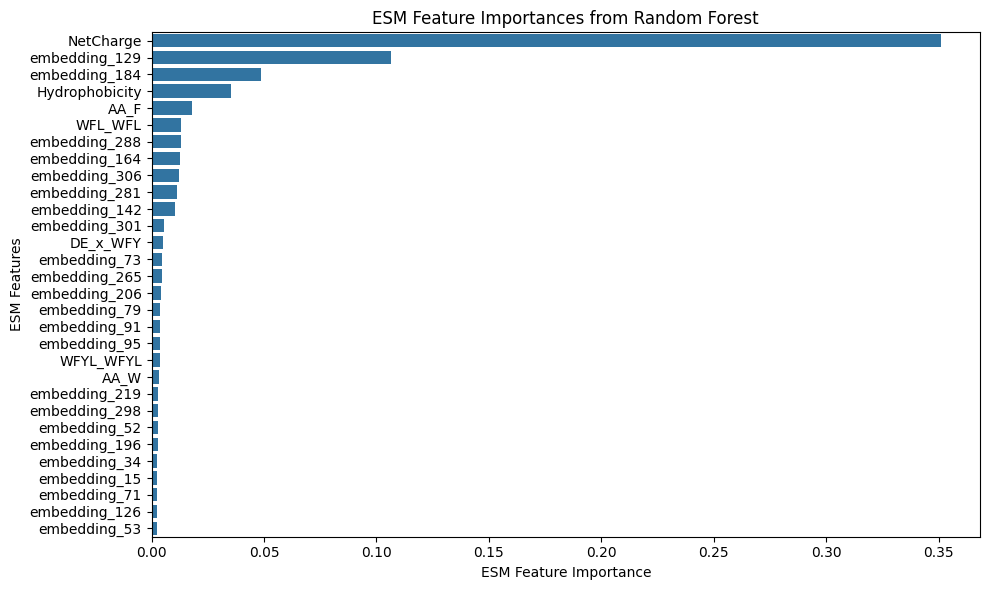

In [89]:
esm_feature_importances = esm_random_forest_reg.named_steps['randomforestregressor'].feature_importances_
esm_feature_names = X_esm.columns
esm_sorted_indices = np.argsort(esm_feature_importances)[::-1]

top_k = 30

sorted_esm_feature_importances = esm_feature_importances[esm_sorted_indices][:top_k]
sorted_esm_feature_names = esm_feature_names[esm_sorted_indices][:top_k]
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_esm_feature_importances, y=sorted_esm_feature_names)
plt.xlabel("ESM Feature Importance")
plt.ylabel("ESM Features")
plt.title("ESM Feature Importances from Random Forest")
plt.tight_layout()
#plt.savefig("GCN4_feature_importances.png")
plt.show()